In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
import scipy.sparse as sp

from randcolorgraphs.utils.calculate_katz import calculate_katz

def get_edge_vector_from_adj_matrix(adj_matrix):
    sparse_matrix = sp.csr_matrix(adj_matrix)
    row_indices, col_indices = sparse_matrix.nonzero()
    edge_vector = np.vstack((row_indices, col_indices)).T
    return edge_vector

def generate_adjacency_matrix_and_katz_vector(n, p, seed=42, alpha=0.1, beta=1.0):
    G = nx.erdos_renyi_graph(n, p, directed=True, seed=seed)
    A_G = nx.adjacency_matrix(G).astype(np.float64)


    eigenvalues, _ = eigs(A_G, k=1, which='LM')  # 'LM': Largest Magnitude, tol is tolerance
    spectral_radius_G = np.abs(eigenvalues).max()
    print(f"Spectral Radius: {spectral_radius_G}, alpha_max = {1/spectral_radius_G}")
    print("calculating katz")
    katz_centrality = calculate_katz(A_G, alpha = alpha, beta=beta)
    print("done calculating katz")
    # Reorder nodes based on Katz centrality
    sorted_indices = np.argsort(katz_centrality)
    sorted_nodes = np.array(G.nodes())[sorted_indices]

    # Generate the adjacency matrix
    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted_nodes)

    sorted_katz_vector = katz_centrality[sorted_indices]

    assert np.allclose(sorted_katz_vector, calculate_katz(adj_matrix.astype(np.float64), alpha = alpha, beta=beta))
    return adj_matrix, sorted_katz_vector


In [ ]:
n = 500
p = 6/n
adj_matrix, katz_vector = generate_adjacency_matrix_and_katz_vector(n=n, p=p, alpha=0.1)
edges = get_edge_vector_from_adj_matrix(adj_matrix)

In [ ]:
from randcolorgraphs.algorithms.linear_scalarization.unoptimized_greedy_search import unoptimized_greedy_search_linear_scalarization
w = np.exp(-9)

# Can go to n ~ 500; smaller w -> much slower
clusters, _ = unoptimized_greedy_search_linear_scalarization(katz_vector, adj_matrix.todense(), np.array([0]*len(katz_vector), dtype=np.int64), w=w, pam_cluster_dist=2)

In [ ]:
from randcolorgraphs.algorithms.linear_scalarization.optimal_contiguous.optimal_contiguous_linear_scalarization_algo import optimal_contiguous_linear_scalarization_algo

# Can go up to n ~ 2_000; indepedented of w
clusters = optimal_contiguous_linear_scalarization_algo(katz_vector, adj_matrix.todense(), w)

In [2]:
import numba
from numba import njit

# Define enums using integer constants
RED = 0
GREEN = 1
BLUE = 2

@njit
def use_enum(color):
    if color == RED:
        return "Red"
    elif color == GREEN:
        return "Green"
    elif color == BLUE:
        return "Blue"
    else:
        return "Unknown"

# Test the function
print(use_enum(RED))    # Output: Red
print(use_enum(GREEN))  # Output: Green
print(use_enum(BLUE))   # Output: Blue
print(use_enum(3))      # Output: Unknown


Red
Green
Blue
Unknown


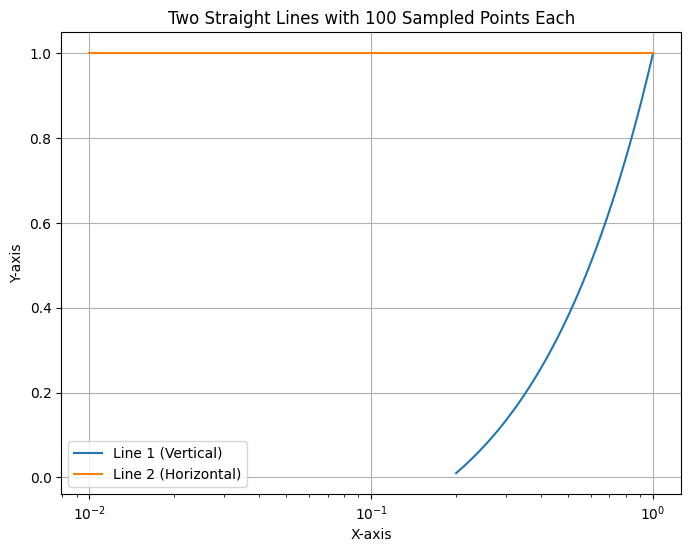

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define the start and end points
start_point1 = [1, 1]
end_point1 = [0.2, 0.01]
start_point2 = [1, 1]
end_point2 = [0.01, 1]

# Generate 100 points for each line
line1_x = np.linspace(start_point1[0], end_point1[0], 100)
line1_y = np.linspace(start_point1[1], end_point1[1], 100)

line2_x = np.linspace(start_point2[0], end_point2[0], 100)
line2_y = np.linspace(start_point2[1], end_point2[1], 100)

# Plot the lines
plt.figure(figsize=(8, 6))
plt.plot(line1_x, line1_y, label='Line 1 (Vertical)')
plt.plot(line2_x, line2_y, label='Line 2 (Horizontal)')

# Adding labels and title
plt.xscale('log')


plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Two Straight Lines with 100 Sampled Points Each')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
